# Imports

In [78]:
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import numpy as np
import gradio as gr
import datetime

In [79]:
import sys
ROOT = '../'
sys.path.append(ROOT)  # Add the root folder to the sys.path

In [80]:
from config import *
from backtest_config import *
from utils.strategies import *

# Reload the configuration
from importlib import reload
reload(sys.modules['config'])
reload(sys.modules['backtest_config'])
reload(sys.modules['utils.strategies'])

from config import *
from backtest_config import *
from utils.strategies import *

# Parameters

In [123]:
# Parameters
start_date = '2016-01-01'
end_date = '2024-07-30'
initial_capital = 100000
consider_commission_rate = True
commission_rate = 0.01
model_name = "gemini" # phi, mistral, llama, qwen
strategy = STRATEGIES[3] # 1 - Invest all, 2 - Dollar cost averaging, 3 - Fixed investment
daily_budget_selected = "Percentage of capital" # Fixed amount | Percentage of capital
fixed_daily_budget = 1000
percentage_daily_budget = 0.1

# Pipeline

In [124]:
def compute_profits_and_losses(portfolio_value, initial_capital):
    # Get the final balance
    final_balance = portfolio_value[-1]

    # Compute the total profit (final balance - initial balance)
    pnl = final_balance - initial_capital
    percentage_pnl = pnl / initial_capital * 100

    # Use only 2 decimals
    pnl = round(pnl, 2)
    percentage_pnl = round(percentage_pnl, 2)
    final_balance = round(final_balance, 2)

    return pnl, percentage_pnl, final_balance

In [125]:
def bold_max(df, column):
    max_value = df[column].max()
    return [f"$\\mathbf{{{x}}}$" if x == max_value else x for x in df[column]]

## Single model

In [126]:
def display_backtest_table_single_model(model, pnl, percentage_pnl, final_balance):
    # Uppercase the first letter of the model name
    model = model.capitalize()
    
    df_formatted = pd.DataFrame({
        r"$\mathbf{Model \ Values}$": [rf"$\mathbf{{{model}}}$"],
        r"$\mathbf{Final Balance (\$)}$": [final_balance],
        r"$\mathbf{PnL (\$)}$": [pnl],
        r"$\mathbf{PnL (\%)}$": [percentage_pnl]
    })
    
    # Create a figure and axis for displaying the table
    fig, ax = plt.subplots(figsize=(10, 1))  # Reduced figure height to minimize spaces

    # Hide axes
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_frame_on(False)

    # Create the table
    table = ax.table(cellText=df_formatted.values, colLabels=df_formatted.columns, cellLoc='center', loc='center')

    # Adjust table scale for better readability
    table.scale(1.5, 1.5)

    # Set a title for the table
    plt.title("Model Performance Summary")

    # Display all the parameters
    # If strategy == STRATEGIES[1] -> Display: strategy, start_date, end_date, initial_capital, commission_rate
    # If strategy == STRATEGIES[2] or strategy == STRATEGIES[3] and daily_budget_selected == "Fixed amount" -> Display: strategy, start_date, end_date, initial_capital, fixed_daily_budget, commission_rate
    # If strategy == STRATEGIES[2] or strategy == STRATEGIES[3] and daily_budget_selected == "Percentage of capital" -> Display: strategy, start_date, end_date, initial_capital, percentage_daily_budget, commission_rate
  
    if strategy == STRATEGIES[1]:   
        text = f"Strategy: {strategy}, Start date: {start_date}, End date: {end_date}, Initial capital: {initial_capital}, Commission rate: {commission_rate}"
    elif strategy == STRATEGIES[2] or strategy == STRATEGIES[3]:
        if daily_budget_selected == "Fixed amount":
            text = f"Strategy: {strategy}, Start date: {start_date}, End date: {end_date}, Initial capital: {initial_capital}, Fixed daily budget: {fixed_daily_budget}, Commission rate: {commission_rate}"
        elif daily_budget_selected == "Percentage of capital":
            text = f"Strategy: {strategy}, Start date: {start_date}, End date: {end_date}, Initial capital: {initial_capital}, Percentage initial capital: {percentage_daily_budget}, Commission rate: {commission_rate}"
        else:
            raise ValueError("Invalid daily budget selected!")
    else:
        raise ValueError("Invalid strategy!")

    # Minimize the space between the table and the text
    plt.subplots_adjust(top=0.85, bottom=0.2)

    # Display the strategy information below the table
    ax.text(0.5, -0.1, text, ha='center', va='center', fontsize=10, transform=ax.transAxes)

    # Display the table
    plt.show()

In [127]:
def plot_data_single_model(daily_budget_selected, portfolio_value, dataset, orders, investments=None):
    # Check if investments are provided and set the number of rows
    rows = 3 if investments else 2

    layout = dict(
        hoversubplots="axis",
        title="Bitcoin Price, Portfolio value, and Investments over Time - Strategy: " + strategy,
        xaxis_title="Days",
        hovermode="x unified",
        grid=dict(rows=rows, columns=1),
        height=800
    )

    if investments:
        data = [
            go.Scatter(x=dataset['timestamp'], y=dataset['close'], name='Bitcoin Price', xaxis="x", yaxis="y"),
            go.Scatter(x=dataset['timestamp'], y=portfolio_value, name='Portfolio value', xaxis="x", yaxis="y2"),
            go.Scatter(x=dataset['timestamp'], y=investments, name='Investments', xaxis="x", yaxis="y3")
        ]
    else:
        data = [
            go.Scatter(x=dataset['timestamp'], y=dataset['close'], name='Bitcoin Price', xaxis="x", yaxis="y"),
            go.Scatter(x=dataset['timestamp'], y=portfolio_value, name='Portfolio value', xaxis="x", yaxis="y2")
        ]

    fig = go.Figure(data=data, layout=layout)

    # Add buy and sell operations to the plot
    buy_added = False
    sell_added = False

    for order in orders:
        if order[1] == 'buy':
            showlegend = not buy_added
            fig.add_trace(go.Scatter(
                x=[order[0]], 
                y=[order[4]], 
                mode='markers', 
                name='Buy', 
                marker=dict(color='green', size=10),
                showlegend=showlegend
            ))
            buy_added = True
        elif order[1] == 'sell':
            showlegend = not sell_added
            fig.add_trace(go.Scatter(
                x=[order[0]], 
                y=[order[4]], 
                mode='markers', 
                name='Sell', 
                marker=dict(color='red', size=10),
                showlegend=showlegend
            ))
            sell_added = True

    # Display all the parameters
    # If strategy == STRATEGIES[1] -> Display: strategy, start_date, end_date, initial_capital, commission_rate
    # If strategy == STRATEGIES[2] or strategy == STRATEGIES[3] and daily_budget_selected == "Fixed amount" -> Display: strategy, start_date, end_date, initial_capital, fixed_daily_budget, commission_rate
    # If strategy == STRATEGIES[2] or strategy == STRATEGIES[3] and daily_budget_selected == "Percentage of capital" -> Display: strategy, start_date, end_date, initial_capital, percentage_daily_budget, commission_rate
    if strategy == STRATEGIES[1]:
        text = f"Strategy: {strategy}, Start date: {start_date}, End date: {end_date}, Initial capital: {initial_capital}, Commission rate: {commission_rate}"
    elif strategy == STRATEGIES[2] or strategy == STRATEGIES[3]:
        if daily_budget_selected == "Fixed amount":
            text = f"Strategy: {strategy}, Start date: {start_date}, End date: {end_date}, Initial capital: {initial_capital}, Fixed daily budget: {fixed_daily_budget}, Commission rate: {commission_rate}"
        elif daily_budget_selected == "Percentage of capital":
            text = f"Strategy: {strategy}, Start date: {start_date}, End date: {end_date}, Initial capital: {initial_capital}, Percentage of capital: {percentage_daily_budget}, Commission rate: {commission_rate}"
        else:
            raise ValueError("Invalid daily budget selected!")
    else:
        raise ValueError("Invalid strategy!")
    

    fig.update_layout(
        annotations=[
            go.layout.Annotation(
                x=-0.01,
                y=1.05,
                xref='paper',
                yref='paper',
                text=text,
                showarrow=False,
                font=dict(
                    size=14
                )
            )
        ]
    )

    # Show the plot
    fig.show()

In [128]:
def run_backtest_and_display_plot_single_model(start_date,
            end_date,
            initial_capital,
            consider_commission_rate,
            commission_rate,
            model_name,
            strategy,
            fixed_daily_budget,
            percentage_daily_budget,
            daily_budget_selected):

    # Set the path to the dataset
    MERGED_GEMINI_OPINION_DATASET_PATH = os.path.join(ROOT, ANNOTATED_DATASET_PATH, "merged_no_text_daily_gemini-1.5-flash_opinion.csv")
    MERGED_PHI_OPINION_DATASET_PATH = os.path.join(ROOT, ANNOTATED_DATASET_PATH, "merged_no_text_daily_phi3_3.8b-mini-128k-instruct-q8_0_opinion.csv")
    MERGED_MISTRAL_OPINION_DATASET_PATH = os.path.join(ROOT, ANNOTATED_DATASET_PATH, "merged_no_text_daily_mistral-nemo_12b-instruct-2407-q5_K_S_opinion.csv")
    MERGED_LLAMA_OPINION_DATASET_PATH = os.path.join(ROOT, ANNOTATED_DATASET_PATH, "merged_no_text_daily_llama3.1_8b-instruct-q6_K_opinion.csv")
    MERGED_QWEN_OPINION_DATASET_PATH = os.path.join(ROOT, ANNOTATED_DATASET_PATH, "merged_no_text_daily_qwen2_7b-instruct-q8_0_opinion.csv")

    # Load the dataset
    def load_dataset(dataset_path):
        dataset = pd.read_csv(dataset_path) # Load the dataset
        dataset = dataset[:-1] # Remove the last row

        return dataset

    # Load the datasets
    if model_name == "gemini":
        dataset = load_dataset(MERGED_GEMINI_OPINION_DATASET_PATH)
    elif model_name == "phi":
        dataset = load_dataset(MERGED_PHI_OPINION_DATASET_PATH)
    elif model_name == "mistral":
        dataset = load_dataset(MERGED_MISTRAL_OPINION_DATASET_PATH)
    elif model_name == "llama":
        dataset = load_dataset(MERGED_LLAMA_OPINION_DATASET_PATH)
    elif model_name == "qwen":
        dataset = load_dataset(MERGED_QWEN_OPINION_DATASET_PATH)
    else:
        raise ValueError("Invalid model name!")

    # Check start and end date of the dataset
    start_date_dataset = datetime.datetime.strptime(dataset['timestamp'].min(), "%Y-%m-%d").date()
    end_date_dataset = datetime.datetime.strptime(dataset['timestamp'].max(), "%Y-%m-%d").date()

    # Convert start_date and end_date to datetime.date objects
    start_date = datetime.datetime.strptime(start_date, "%Y-%m-%d").date()
    end_date = datetime.datetime.strptime(end_date, "%Y-%m-%d").date()
    
    # Filter the dataset based on the start and end date
    dataset['timestamp'] = pd.to_datetime(dataset['timestamp']).dt.date
    dataset = dataset[(dataset['timestamp'] >= start_date) & (dataset['timestamp'] <= end_date)]

    # Reset the index
    dataset.reset_index(drop=True, inplace=True)
    
    if strategy == STRATEGIES[1]:
        orders, portfolio_value = invest_all(dataset, initial_capital, commission_rate, consider_fee=consider_commission_rate)
        fig = plot_data_single_model(daily_budget_selected, portfolio_value, dataset, orders)
    elif strategy == STRATEGIES[2]:
        orders, investments, portfolio_value  = dollar_cost_averaging(dataset, initial_capital, fixed_daily_budget, percentage_daily_budget, daily_budget_selected, commission_rate, consider_fee=consider_commission_rate)
        fig = plot_data_single_model(daily_budget_selected, portfolio_value, dataset, orders, investments)
    elif strategy == STRATEGIES[3]:
        orders, investments, portfolio_value = fixed_investment(dataset, initial_capital, fixed_daily_budget, percentage_daily_budget, daily_budget_selected, commission_rate, consider_fee=consider_commission_rate)
        fig = plot_data_single_model(daily_budget_selected, portfolio_value, dataset, orders, investments)
    else:
        raise ValueError("Invalid strategy!")

    # Compute the profits and losses
    pnl, percentage_pnl, final_balance = compute_profits_and_losses(portfolio_value, initial_capital)

    return fig, pnl, percentage_pnl, final_balance

## All models

In [129]:
def display_backtest_table_all_models(initial_capital, gemini_pnl, gemini_percentage_pnl, gemini_final_balance,
            phi_pnl, phi_percentage_pnl, phi_final_balance,
            mistral_pnl, mistral_percentage_pnl, mistral_final_balance,
            llama_pnl, llama_percentage_pnl, llama_final_balance,
            qwen_pnl, qwen_percentage_pnl, qwen_final_balance):
    
    # Create a dataframe for the table
    df_formatted = pd.DataFrame({
        r"$\mathbf{Models / Values}$": [r"$\mathbf{Gemini}$", r"$\mathbf{Phi}$", r"$\mathbf{Mistral}$", r"$\mathbf{Llama}$", r"$\mathbf{Qwen}$"],
        r"$\mathbf{Final Balance (\$)}$": [gemini_final_balance, phi_final_balance, mistral_final_balance, llama_final_balance, qwen_final_balance],
        r"$\mathbf{PnL (\$)}$": [gemini_pnl, phi_pnl, mistral_pnl, llama_pnl, qwen_pnl],
        r"$\mathbf{PnL (\%)}$": [gemini_percentage_pnl, phi_percentage_pnl, mistral_percentage_pnl, llama_percentage_pnl, qwen_percentage_pnl]
    })

    # Bold the highest values in each column
    df_formatted[r"$\mathbf{Final Balance (\$)}$"] = bold_max(df_formatted, r"$\mathbf{Final Balance (\$)}$")
    df_formatted[r"$\mathbf{PnL (\$)}$"] = bold_max(df_formatted, r"$\mathbf{PnL (\$)}$")
    df_formatted[r"$\mathbf{PnL (\%)}$"] = bold_max(df_formatted, r"$\mathbf{PnL (\%)}$")

    # Create a figure and axis for displaying the table
    fig, ax = plt.subplots(figsize=(10, 2))  # Reduce the figure height to minimize spaces

    # Hide axes
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_frame_on(False)

    # Create the table
    table = ax.table(cellText=df_formatted.values, colLabels=df_formatted.columns, cellLoc='center', loc='center')

    # Adjust table scale for better readability
    table.scale(1.5, 1.5)

    # Set a title for the table
    plt.title("Models Performance Summary")

    # Display all the parameters
    # If strategy == STRATEGIES[1] -> Display: strategy, start_date, end_date, initial_capital, commission_rate
    # If strategy == STRATEGIES[2] or strategy == STRATEGIES[3] and daily_budget_selected == "Fixed amount" -> Display: strategy, start_date, end_date, initial_capital, fixed_daily_budget, commission_rate
    # If strategy == STRATEGIES[2] or strategy == STRATEGIES[3] and daily_budget_selected == "Percentage of capital" -> Display: strategy, start_date, end_date, initial_capital, percentage_daily_budget, commission_rate
  
    if strategy == STRATEGIES[1]:   
        text = f"Strategy: {strategy}, Start date: {start_date}, End date: {end_date}, Initial capital: {initial_capital}, Commission rate: {commission_rate}"
    elif strategy == STRATEGIES[2] or strategy == STRATEGIES[3]:
        if daily_budget_selected == "Fixed amount":
            text = f"Strategy: {strategy}, Start date: {start_date}, End date: {end_date}, Initial capital: {initial_capital}, Fixed daily budget: {fixed_daily_budget}, Commission rate: {commission_rate}"
        elif daily_budget_selected == "Percentage of capital":
            text = f"Strategy: {strategy}, Start date: {start_date}, End date: {end_date}, Initial capital: {initial_capital}, Percentage of capital: {percentage_daily_budget}, Commission rate: {commission_rate}"
        else:
            raise ValueError("Invalid daily budget selected!")
    else:
        raise ValueError("Invalid strategy!")

    # Minimize the space between the table and the text
    plt.subplots_adjust(top=0.85, bottom=0.2)

    # Display the strategy information below the table
    ax.text(0.5, -0.1, text, ha='center', va='center', fontsize=10, transform=ax.transAxes)

    # Display the table
    plt.show()

    return fig

In [130]:
def plot_data_all_models(daily_budget_selected,
            gemini_portfolio_value, 
            phi_portfolio_value, 
            mistral_portfolio_value, 
            llama_portfolio_value, 
            qwen_portfolio_value, 
            gemini_dataset, 
            phi_dataset, 
            mistral_dataset, 
            llama_dataset, 
            qwen_dataset, 
            gemini_orders, 
            phi_orders, 
            mistral_orders, 
            llama_orders, 
            qwen_orders
            ):
    rows = 2

    layout = dict(
        hoversubplots="axis",
        title="Bitcoin Price, Portfolio value over Time",
        xaxis_title="Days",
        hovermode="x unified",
        grid=dict(rows=rows, columns=1),
        height=800
    )

    data = [
        go.Scatter(x=gemini_dataset['timestamp'], y=gemini_dataset['close'], name='Bitcoin Price', xaxis="x", yaxis="y"),
        go.Scatter(x=gemini_dataset['timestamp'], y=gemini_portfolio_value, name='Gemini Portfolio value', xaxis="x", yaxis="y2"),
        go.Scatter(x=phi_dataset['timestamp'], y=phi_portfolio_value, name='Phi Portfolio value', xaxis="x", yaxis="y2"),
        go.Scatter(x=mistral_dataset['timestamp'], y=mistral_portfolio_value, name='Mistral Portfolio value', xaxis="x", yaxis="y2"),
        go.Scatter(x=llama_dataset['timestamp'], y=llama_portfolio_value, name='Llama Portfolio value', xaxis="x", yaxis="y2"),
        go.Scatter(x=qwen_dataset['timestamp'], y=qwen_portfolio_value, name='Qwen Portfolio value', xaxis="x", yaxis="y2"),            
    ]

    fig = go.Figure(data=data, layout=layout)

    if strategy == STRATEGIES[1]:
        text = f"Strategy: {strategy}, Start date: {start_date}, End date: {end_date}, Initial capital: {initial_capital}, Commission rate: {commission_rate}"
    elif strategy == STRATEGIES[2] or strategy == STRATEGIES[3]:
        if daily_budget_selected == "Fixed amount":
            text = f"Strategy: {strategy}, Start date: {start_date}, End date: {end_date}, Initial capital: {initial_capital}, Fixed daily budget: {fixed_daily_budget}, Commission rate: {commission_rate}"
        elif daily_budget_selected == "Percentage of capital":
            text = f"Strategy: {strategy}, Start date: {start_date}, End date: {end_date}, Initial capital: {initial_capital}, Percentage of capital: {percentage_daily_budget}, Commission rate: {commission_rate}"
        else:
            raise ValueError("Invalid daily budget selected!")
    else:
        raise ValueError("Invalid strategy!")

    fig.update_layout(
        annotations=[
            go.layout.Annotation(
                x=0.003,
                y=1.05,
                xref='paper',
                yref='paper',
                text=text,
                showarrow=False,
                font=dict(
                    size=14
                )
            )
        ]
    )


    # Show the plot
    fig.show()

    return fig

def plot_data_with_investments_all_models(daily_budget_selected,
            gemini_portfolio_value, 
            phi_portfolio_value, 
            mistral_portfolio_value, 
            llama_portfolio_value, 
            qwen_portfolio_value, 
            gemini_dataset, 
            phi_dataset, 
            mistral_dataset, 
            llama_dataset, 
            qwen_dataset, 
            gemini_orders, 
            phi_orders, 
            mistral_orders, 
            llama_orders, 
            qwen_orders,
            gemini_investments,
            phi_investments,
            mistral_investments,
            llama_investments,
            qwen_investments
            ):
    rows = 3 

    investments = True if strategy == STRATEGIES[2] or strategy == STRATEGIES[3] else False

    layout = dict(
        hoversubplots="axis",
        title="Bitcoin Price, Portfolio value, and Investments over Time",
        xaxis_title="Days",
        hovermode="x unified",
        grid=dict(rows=rows, columns=1),
        height=800
    )

    data = [
        go.Scatter(x=gemini_dataset['timestamp'], y=gemini_dataset['close'], name='Bitcoin Price', xaxis="x", yaxis="y"),
        go.Scatter(x=gemini_dataset['timestamp'], y=gemini_portfolio_value, name='Gemini Portfolio value', xaxis="x", yaxis="y2"),
        go.Scatter(x=phi_dataset['timestamp'], y=phi_portfolio_value, name='Phi Portfolio value', xaxis="x", yaxis="y2"),
        go.Scatter(x=mistral_dataset['timestamp'], y=mistral_portfolio_value, name='Mistral Portfolio value', xaxis="x", yaxis="y2"),
        go.Scatter(x=llama_dataset['timestamp'], y=llama_portfolio_value, name='Llama Portfolio value', xaxis="x", yaxis="y2"),
        go.Scatter(x=qwen_dataset['timestamp'], y=qwen_portfolio_value, name='Qwen Portfolio value', xaxis="x", yaxis="y2"),
        go.Scatter(x=gemini_dataset['timestamp'], y=gemini_investments, name='Gemini Investments', xaxis="x", yaxis="y3"),
        go.Scatter(x=phi_dataset['timestamp'], y=phi_investments, name='Phi Investments', xaxis="x", yaxis="y3"),
        go.Scatter(x=mistral_dataset['timestamp'], y=mistral_investments, name='Mistral Investments', xaxis="x", yaxis="y3"),
        go.Scatter(x=llama_dataset['timestamp'], y=llama_investments, name='Llama Investments', xaxis="x", yaxis="y3"),
        go.Scatter(x=qwen_dataset['timestamp'], y=qwen_investments, name='Qwen Investments', xaxis="x", yaxis="y3"),        
    ]

    fig = go.Figure(data=data, layout=layout)

    if strategy == STRATEGIES[1]:
        text = f"Strategy: {strategy}, Start date: {start_date}, End date: {end_date}, Initial capital: {initial_capital}, Commission rate: {commission_rate}"
    elif strategy == STRATEGIES[2] or strategy == STRATEGIES[3]:
        if daily_budget_selected == "Fixed amount":
            text = f"Strategy: {strategy}, Start date: {start_date}, End date: {end_date}, Initial capital: {initial_capital}, Fixed daily budget: {fixed_daily_budget}, Commission rate: {commission_rate}"
        elif daily_budget_selected == "Percentage of capital":
            text = f"Strategy: {strategy}, Start date: {start_date}, End date: {end_date}, Initial capital: {initial_capital}, Percentage of capital: {percentage_daily_budget}, Commission rate: {commission_rate}"
        else:
            raise ValueError("Invalid daily budget selected!")
    else:
        raise ValueError("Invalid strategy!")

    fig.update_layout(
        annotations=[
            go.layout.Annotation(
                x=0.003,
                y=1.05,
                xref='paper',
                yref='paper',
                text=text,
                showarrow=False,
                font=dict(
                    size=14
                )
            )
        ]
    )


    # Show the plot
    fig.show()

    return fig

In [131]:
def run_backtest_and_display_plot_all_models(start_date,
            end_date,
            initial_capital,
            consider_commission_rate,
            commission_rate,
            strategy,
            fixed_daily_budget,
            percentage_daily_budget,
            daily_budget_selected):

    # Set the path to the dataset
    MERGED_GEMINI_OPINION_DATASET_PATH = os.path.join(ROOT, ANNOTATED_DATASET_PATH, "merged_no_text_daily_gemini-1.5-flash_opinion.csv")
    MERGED_PHI_OPINION_DATASET_PATH = os.path.join(ROOT, ANNOTATED_DATASET_PATH, "merged_no_text_daily_phi3_3.8b-mini-128k-instruct-q8_0_opinion.csv")
    MERGED_MISTRAL_OPINION_DATASET_PATH = os.path.join(ROOT, ANNOTATED_DATASET_PATH, "merged_no_text_daily_mistral-nemo_12b-instruct-2407-q5_K_S_opinion.csv")
    MERGED_LLAMA_OPINION_DATASET_PATH = os.path.join(ROOT, ANNOTATED_DATASET_PATH, "merged_no_text_daily_llama3.1_8b-instruct-q6_K_opinion.csv")
    MERGED_QWEN_OPINION_DATASET_PATH = os.path.join(ROOT, ANNOTATED_DATASET_PATH, "merged_no_text_daily_qwen2_7b-instruct-q8_0_opinion.csv")

    # Load the dataset
    def load_dataset(dataset_path):
        dataset = pd.read_csv(dataset_path) # Load the dataset
        dataset = dataset[:-1] # Remove the last row

        return dataset

    gemini_dataset = load_dataset(MERGED_GEMINI_OPINION_DATASET_PATH)
    phi_dataset = load_dataset(MERGED_PHI_OPINION_DATASET_PATH)
    mistral_dataset = load_dataset(MERGED_MISTRAL_OPINION_DATASET_PATH)
    llama_dataset = load_dataset(MERGED_LLAMA_OPINION_DATASET_PATH)
    qwen_dataset = load_dataset(MERGED_QWEN_OPINION_DATASET_PATH)

    # Convert start_date and end_date to datetime.date objects
    start_date = datetime.datetime.strptime(start_date, "%Y-%m-%d").date()
    end_date = datetime.datetime.strptime(end_date, "%Y-%m-%d").date()
    
    # Filter the dataset based on the start and end date
    gemini_dataset['timestamp'] = pd.to_datetime(gemini_dataset['timestamp']).dt.date
    gemini_dataset = gemini_dataset[(gemini_dataset['timestamp'] >= start_date) & (gemini_dataset['timestamp'] <= end_date)]

    phi_dataset['timestamp'] = pd.to_datetime(phi_dataset['timestamp']).dt.date
    phi_dataset = phi_dataset[(phi_dataset['timestamp'] >= start_date) & (phi_dataset['timestamp'] <= end_date)]

    mistral_dataset['timestamp'] = pd.to_datetime(mistral_dataset['timestamp']).dt.date
    mistral_dataset = mistral_dataset[(mistral_dataset['timestamp'] >= start_date) & (mistral_dataset['timestamp'] <= end_date)]

    llama_dataset['timestamp'] = pd.to_datetime(llama_dataset['timestamp']).dt.date
    llama_dataset = llama_dataset[(llama_dataset['timestamp'] >= start_date) & (llama_dataset['timestamp'] <= end_date)]

    qwen_dataset['timestamp'] = pd.to_datetime(qwen_dataset['timestamp']).dt.date
    qwen_dataset = qwen_dataset[(qwen_dataset['timestamp'] >= start_date) & (qwen_dataset['timestamp'] <= end_date)]

    # Reset the index
    gemini_dataset.reset_index(drop=True, inplace=True)
    phi_dataset.reset_index(drop=True, inplace=True)
    mistral_dataset.reset_index(drop=True, inplace=True)
    llama_dataset.reset_index(drop=True, inplace=True)
    qwen_dataset.reset_index(drop=True, inplace=True)
    
    if strategy == STRATEGIES[1]:
        gemini_orders, gemini_portfolio_value = invest_all(gemini_dataset,
                                                            initial_capital,
                                                            commission_rate,
                                                            consider_fee=consider_commission_rate)
        phi_orders, phi_portfolio_value = invest_all(phi_dataset,
                                                    initial_capital,
                                                    commission_rate,
                                                    consider_fee=consider_commission_rate)
        mistral_orders, mistral_portfolio_value = invest_all(mistral_dataset, 
                                                            initial_capital,
                                                            commission_rate,
                                                            consider_fee=consider_commission_rate)
        llama_orders, llama_portfolio_value = invest_all(llama_dataset, 
                                                        initial_capital,
                                                        commission_rate,
                                                        consider_fee=consider_commission_rate)
        qwen_orders, qwen_portfolio_value = invest_all(qwen_dataset, 
                                                    initial_capital,
                                                    commission_rate,
                                                    consider_fee=consider_commission_rate)
        fig = plot_data_all_models(daily_budget_selected,
                        gemini_portfolio_value, 
                        phi_portfolio_value, 
                        mistral_portfolio_value, 
                        llama_portfolio_value, 
                        qwen_portfolio_value, 
                        gemini_dataset, 
                        phi_dataset, 
                        mistral_dataset, 
                        llama_dataset, 
                        qwen_dataset, 
                        gemini_orders, 
                        phi_orders, 
                        mistral_orders, 
                        llama_orders, 
                        qwen_orders)
    elif strategy == STRATEGIES[2]:
        gemini_orders, gemini_investments, gemini_portfolio_value = dollar_cost_averaging(gemini_dataset, 
                                                                                            initial_capital, 
                                                                                            fixed_daily_budget, 
                                                                                            percentage_daily_budget, 
                                                                                            daily_budget_selected, 
                                                                                            commission_rate, 
                                                                                            consider_fee=consider_commission_rate)
        phi_orders, phi_investments, phi_portfolio_value = dollar_cost_averaging(phi_dataset, 
                                                                                    initial_capital, 
                                                                                    fixed_daily_budget, 
                                                                                    percentage_daily_budget, 
                                                                                    daily_budget_selected, 
                                                                                    commission_rate, 
                                                                                    consider_fee=consider_commission_rate)
        mistral_orders, mistral_investments, mistral_portfolio_value = dollar_cost_averaging(mistral_dataset, 
                                                                                                initial_capital, 
                                                                                                fixed_daily_budget, 
                                                                                                percentage_daily_budget, 
                                                                                                daily_budget_selected, 
                                                                                                commission_rate, 
                                                                                                consider_fee=consider_commission_rate)
        llama_orders, llama_investments, llama_portfolio_value = dollar_cost_averaging(llama_dataset, 
                                                                                        initial_capital, 
                                                                                        fixed_daily_budget, 
                                                                                        percentage_daily_budget, 
                                                                                        daily_budget_selected, 
                                                                                        commission_rate, 
                                                                                        consider_fee=consider_commission_rate)
        qwen_orders, qwen_investments, qwen_portfolio_value = dollar_cost_averaging(qwen_dataset, 
                                                                                    initial_capital, 
                                                                                    fixed_daily_budget, 
                                                                                    percentage_daily_budget, 
                                                                                    daily_budget_selected, 
                                                                                    commission_rate, 
                                                                                    consider_fee=consider_commission_rate)
        fig = plot_data_with_investments_all_models(daily_budget_selected,
                        gemini_portfolio_value, 
                        phi_portfolio_value, 
                        mistral_portfolio_value, 
                        llama_portfolio_value, 
                        qwen_portfolio_value, 
                        gemini_dataset, 
                        phi_dataset, 
                        mistral_dataset, 
                        llama_dataset, 
                        qwen_dataset, 
                        gemini_orders, 
                        phi_orders, 
                        mistral_orders, 
                        llama_orders, 
                        qwen_orders, 
                        gemini_investments, 
                        phi_investments, 
                        mistral_investments, 
                        llama_investments, 
                        qwen_investments)
    elif strategy == STRATEGIES[3]:
        gemini_orders, gemini_investments, gemini_portfolio_value = fixed_investment(gemini_dataset, 
                                                                                    initial_capital, 
                                                                                    fixed_daily_budget, 
                                                                                    percentage_daily_budget, 
                                                                                    daily_budget_selected, 
                                                                                    commission_rate, 
                                                                                    consider_fee=consider_commission_rate)
        phi_orders, phi_investments, phi_portfolio_value = fixed_investment(phi_dataset, 
                                                                            initial_capital, 
                                                                            fixed_daily_budget, 
                                                                            percentage_daily_budget, 
                                                                            daily_budget_selected, 
                                                                            commission_rate, 
                                                                            consider_fee=consider_commission_rate)
        mistral_orders, mistral_investments, mistral_portfolio_value = fixed_investment(mistral_dataset, 
                                                                                        initial_capital, 
                                                                                        fixed_daily_budget, 
                                                                                        percentage_daily_budget, 
                                                                                        daily_budget_selected, 
                                                                                        commission_rate, 
                                                                                        consider_fee=consider_commission_rate)
        llama_orders, llama_investments, llama_portfolio_value = fixed_investment(llama_dataset, 
                                                                                    initial_capital, 
                                                                                    fixed_daily_budget, 
                                                                                    percentage_daily_budget, 
                                                                                    daily_budget_selected, 
                                                                                    commission_rate, 
                                                                                    consider_fee=consider_commission_rate)
        qwen_orders, qwen_investments, qwen_portfolio_value = fixed_investment(qwen_dataset, 
                                                                                initial_capital, 
                                                                                fixed_daily_budget, 
                                                                                percentage_daily_budget, 
                                                                                daily_budget_selected, 
                                                                                commission_rate, 
                                                                                consider_fee=consider_commission_rate)
        fig = plot_data_with_investments_all_models(daily_budget_selected,
                        gemini_portfolio_value, 
                        phi_portfolio_value, 
                        mistral_portfolio_value, 
                        llama_portfolio_value, 
                        qwen_portfolio_value, 
                        gemini_dataset, 
                        phi_dataset, 
                        mistral_dataset, 
                        llama_dataset, 
                        qwen_dataset, 
                        gemini_orders, 
                        phi_orders, 
                        mistral_orders, 
                        llama_orders, 
                        qwen_orders, 
                        gemini_investments, 
                        phi_investments, 
                        mistral_investments, 
                        llama_investments, 
                        qwen_investments)

    # Compute the profits and losses
    gemini_pnl, gemini_percentage_pnl, gemini_final_balance = compute_profits_and_losses(gemini_portfolio_value, initial_capital)
    phi_pnl, phi_percentage_pnl, phi_final_balance = compute_profits_and_losses(phi_portfolio_value, initial_capital)
    mistral_pnl, mistral_percentage_pnl, mistral_final_balance = compute_profits_and_losses(mistral_portfolio_value, initial_capital)
    llama_pnl, llama_percentage_pnl, llama_final_balance = compute_profits_and_losses(llama_portfolio_value, initial_capital)
    qwen_pnl, qwen_percentage_pnl, qwen_final_balance = compute_profits_and_losses(qwen_portfolio_value, initial_capital)

    return fig, gemini_pnl, gemini_percentage_pnl, gemini_final_balance, phi_pnl, phi_percentage_pnl, phi_final_balance, mistral_pnl, mistral_percentage_pnl, mistral_final_balance, llama_pnl, llama_percentage_pnl, llama_final_balance, qwen_pnl, qwen_percentage_pnl, qwen_final_balance

# [ALL MODELS] Run backtest

In [132]:
# Save the plot as pdf file
if strategy == STRATEGIES[1]:
    strategy_name = "invest_all"
    name = f"{strategy_name}_{start_date}_{end_date}_{initial_capital}_{commission_rate}"
elif strategy == STRATEGIES[2] or strategy == STRATEGIES[3]:
    if strategy == STRATEGIES[2]:
        strategy_name = "dollar_cost_averaging"
    elif strategy == STRATEGIES[3]:
        strategy_name = "fixed_investment"
    if daily_budget_selected == "Fixed amount":
        name = f"{strategy_name}_{start_date}_{end_date}_{initial_capital}_{fixed_daily_budget}_{commission_rate}"
    elif daily_budget_selected == "Percentage of capital":
        name = f"{strategy_name}_{start_date}_{end_date}_{initial_capital}_{percentage_daily_budget}_{commission_rate}"
    else:
        raise ValueError("Invalid daily budget selected!")
else:
    raise ValueError("Invalid strategy!")

In [133]:
# Run the backtest and display the plot
fig, gemini_pnl, gemini_percentage_pnl, gemini_final_balance, phi_pnl, phi_percentage_pnl, phi_final_balance, mistral_pnl, mistral_percentage_pnl, mistral_final_balance, llama_pnl, llama_percentage_pnl, llama_final_balance, qwen_pnl, qwen_percentage_pnl, qwen_final_balance = run_backtest_and_display_plot_all_models(start_date, end_date, initial_capital, consider_commission_rate, commission_rate, strategy, fixed_daily_budget, percentage_daily_budget, daily_budget_selected)

In [134]:
# Save the plot as pdf file
# path = os.path.join(ROOT, DATA_EXPLORATORY_ANALYSIS_PATH, "plots", f"{name}.pdf")
# fig.write_image(path)
# path = os.path.join(ROOT, DATA_EXPLORATORY_ANALYSIS_PATH, "plots", f"{name}.png")
# fig.write_image(path)
print(name)

fixed_investment_2016-01-01_2024-07-30_100000_0.1_0.01


# [SINGLE MODEL] Run backtest

In [135]:
# Run the backtest and display the plot
fig, pnl, percentage_pnl, final_balance = run_backtest_and_display_plot_single_model(start_date, end_date, initial_capital, consider_commission_rate, commission_rate, model_name, strategy, fixed_daily_budget, percentage_daily_budget, daily_budget_selected)

# [ALL MODELS] Tables

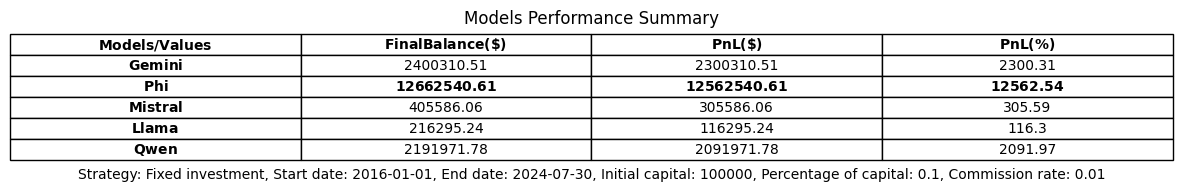

In [136]:
# Display backtest table
fig = display_backtest_table_all_models(initial_capital, gemini_pnl, gemini_percentage_pnl, gemini_final_balance,
            phi_pnl, phi_percentage_pnl, phi_final_balance,
            mistral_pnl, mistral_percentage_pnl, mistral_final_balance,
            llama_pnl, llama_percentage_pnl, llama_final_balance,
            qwen_pnl, qwen_percentage_pnl, qwen_final_balance)

In [137]:
# Save the plot as pdf file
path = os.path.join(ROOT, BACKTEST_PATH, "plots", f"table_{name}.pdf")
fig.savefig(path, bbox_inches='tight')
path = os.path.join(ROOT, BACKTEST_PATH, "plots", f"table_{name}.png")
fig.savefig(path, bbox_inches='tight')

In [138]:
# Save in a .csv file
df = pd.DataFrame({
    "model": ["Gemini", "Phi", "Mistral", "Llama", "Qwen"],
    "final_balance": [gemini_final_balance, phi_final_balance, mistral_final_balance, llama_final_balance, qwen_final_balance],
    "pnl": [gemini_pnl, phi_pnl, mistral_pnl, llama_pnl, qwen_pnl],
    "percentage_pnl": [gemini_percentage_pnl, phi_percentage_pnl, mistral_percentage_pnl, llama_percentage_pnl, qwen_percentage_pnl]
})

path = os.path.join(ROOT, BACKTEST_PATH, "data", f"{name}.csv")
df.to_csv(path, index=False)

### Generate unique table

In [139]:
import os

In [140]:
import sys
ROOT = '../'
sys.path.append(ROOT)  # Add the root folder to the sys.path

In [141]:
from config import *

In [142]:
# Load CSV files
file_1 = os.path.join(ROOT, BACKTEST_PATH, 'data', 'dollar_cost_averaging_2016-01-01_2024-07-30_100000_0.1_0.01.csv')
file_2 = os.path.join(ROOT, BACKTEST_PATH, 'data', 'dollar_cost_averaging_2016-01-01_2024-07-30_100000_1000_0.01.csv')
file_3 = os.path.join(ROOT, BACKTEST_PATH, 'data', 'fixed_investment_2016-01-01_2024-07-30_100000_0.1_0.01.csv')
file_4 = os.path.join(ROOT, BACKTEST_PATH, 'data', 'fixed_investment_2016-01-01_2024-07-30_100000_1000_0.01.csv')
file_5 = os.path.join(ROOT, BACKTEST_PATH, 'data', 'invest_all_2016-01-01_2024-07-30_100000_0.01.csv')

# Reading the files
df1 = pd.read_csv(file_1) # Dollar cost averaging with percentage of capital
df2 = pd.read_csv(file_2) # Dollar cost averaging with fixed daily budget
df3 = pd.read_csv(file_3) # Fixed investment with percentage of capital
df4 = pd.read_csv(file_4) # Fixed investment with fixed daily budget
df5 = pd.read_csv(file_5) # Invest all

# [SINGLE MODEL] Table

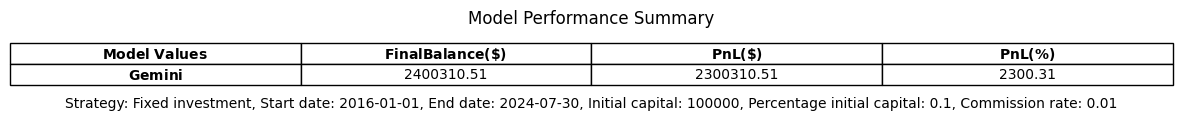

In [143]:
# Display the backtest table
fig = display_backtest_table_single_model(model_name, pnl, percentage_pnl, final_balance)